In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [104]:
df=pd.read_csv('updated.csv')

In [105]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.sort_values(by=['date'], inplace=True)
df.set_index('date', inplace=True)
df.head()

,year,month,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,time_elapsed
date,,,,,,,,,,,
1980-03-08,1980,3,8,-0.02,-109.44,-4.9,1.1,88.293266,25.66,25.97,0
1980-03-09,1980,3,9,-0.02,-109.44,-4.5,2.2,89.798431,25.69,25.28,1
1980-03-10,1980,3,10,-0.02,-109.44,-3.8,1.9,89.044724,25.56,24.31,2
1980-03-12,1980,3,12,-0.02,-109.44,-4.4,0.3,90.482239,24.72,23.64,4
1980-03-13,1980,3,13,-0.02,-109.44,-3.2,0.1,90.417183,24.66,24.34,5


In [106]:
features = df.drop(columns=['s.s.temp.', 'day']).columns
data = df[list(features) + ['s.s.temp.']].values

In [107]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, -1]  # Assuming the last column is your target_column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 56  # You can adjust this based on your dataset and prediction horizon

# Create sequences of data for LSTM
X, y = create_sequences(data, sequence_length)
# Reshape X to 3D array (samples, sequence length, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and test sets
train_size = int(len(X) * 0.80)  # 80% training data, 20% test data
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [108]:
from sklearn.preprocessing import MinMaxScaler
# Initialize MinMaxScaler for scaling features only
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training features and transform
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 56, 100)           44400     
                                                                 
 dropout (Dropout)           (None, 56, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 74651 (291.61 KB)
Trainable params: 74651 (291.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
2348/

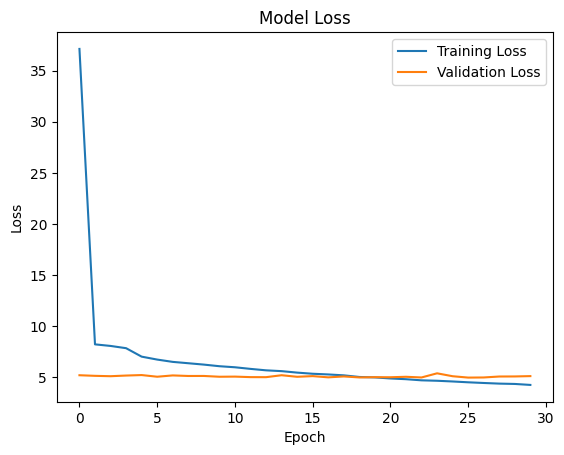

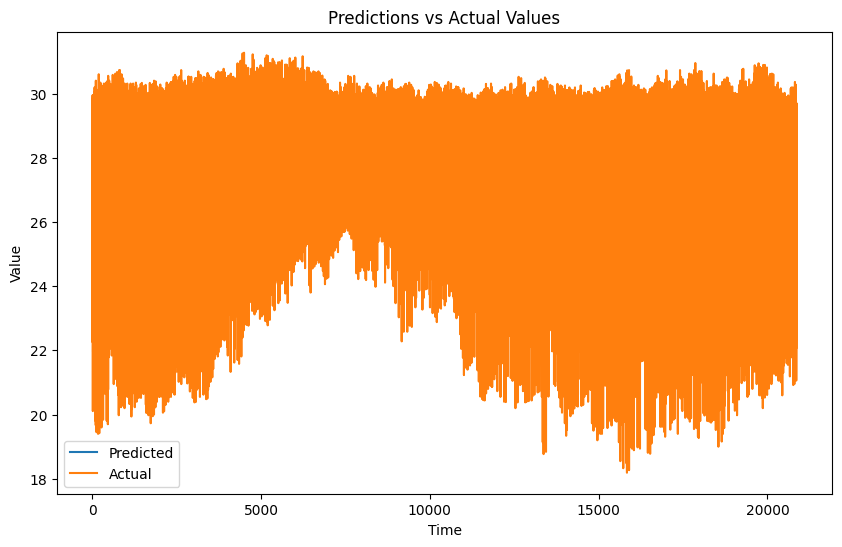

In [109]:
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Print summary of the model
model.summary()

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model on test data
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
predictions = model.predict(X_test_scaled)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f'Test RMSE: {rmse}')

# Calculate R2 score
r2 = r2_score(y_test, predictions)
print(f'R2 score: {r2}')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicted')
plt.plot(y_test, label='Actual')
plt.title('Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()